In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [109]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
path = "../../csv/Mercedes-Benz Greener Manufacturing/"

In [83]:
def feat_to_rem(train, test, columns):
    features=[]
    for col in columns : 
        level_train = list(train[col].value_counts().index)
        level_test = list(test[col].value_counts().index)
        excl_feat = [l for l in level_test if l not in level_train]
        features.extend([col+'_'+ f for f in excl_feat])
    return features

def exclusive_levels(train, test, columns):
    for col in columns:
        train_levels = list(train[col].value_counts().index)
        test_levels = list(test[col].value_counts().index)
        exc_train = [lev for lev in train_levels if lev not in test_levels]
        exc_test = [lev for lev in test_levels if lev not in train_levels]
        print ('Exclusive {0}'.format(col))
        print ('{0} levels in train and not in test : {1}'.format(len(exc_train), exc_train))
        print ('{0} levels in test and not in train : {1}'.format(len(exc_test), exc_test))

In [5]:
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [75]:
train.head(10)
train.shape, test.shape
train.info()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
5,18,92.93,t,b,e,c,d,g,h,s,...,0,0,1,0,0,0,0,0,0,0
6,24,128.76,al,r,e,f,d,f,h,s,...,0,0,0,0,0,0,0,0,0,0
7,25,91.91,o,l,as,f,d,f,j,a,...,0,0,0,0,0,0,0,0,0,0
8,27,108.67,w,s,as,e,d,f,i,h,...,1,0,0,0,0,0,0,0,0,0
9,30,126.99,j,b,aq,c,d,f,a,e,...,0,0,1,0,0,0,0,0,0,0


((4209, 378), (4209, 377))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


Okay, so there are 4209 values in train and test. There are 378 columns including the target variable out of which 8 are object type, 1 is float(target variable 'y') and rest are integer. The integer features except the target variable are binary in nature taking only 2 values : 0 and 1. 

In [6]:
cat_feat = train.select_dtypes(include=['object']).columns
num_feat = train.select_dtypes(include=['int64', 'float64']).columns

cat_feat has all categorical features, while num_feat has all numerical features.

In [77]:
train.isnull().sum().sum()

0

Also we can see that there are no null values. 

Let's first see how are target variable is distributed. 

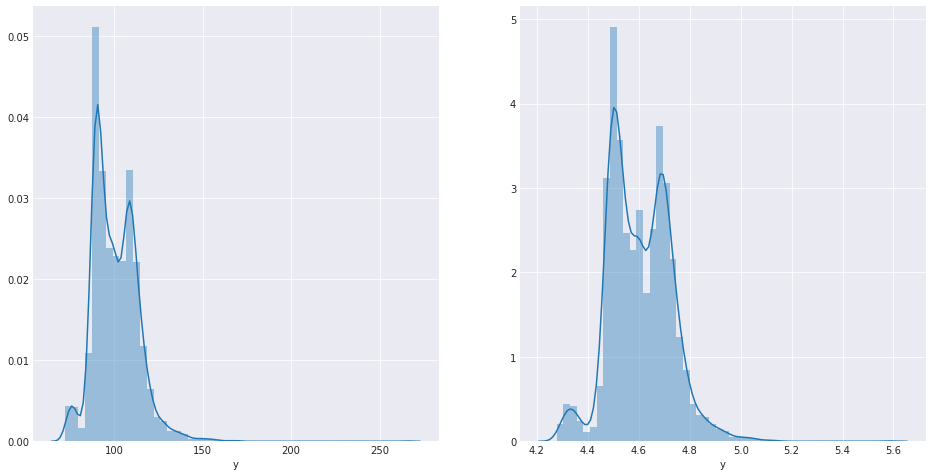

In [164]:
_,ax = plt.subplots(ncols=2, figsize=(16,8))
sns.set_style('darkgrid')
sns.distplot(train['y'], ax=ax[0])
sns.distplot(np.log(train['y']), ax=ax[1])

In [9]:
train['y'].describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

So the target variable 'y'(time in seconds a car took to pass testing) caries from 72.11 to 265.32 with a mean of 100.67 and standard deviation of 12.68 . Also the first plot shows that it is positively skewed and has high kurtosis. 
Since most of the statistical tests require the variable to be normally distributed, lets use log transformation on 'y' to bring it closer to normal. 

Before Transformation : 
Skewness : 1.2060958289669412
Kurtosis : 7.899893252938124

After Transformation : 
Skewness : 0.38984118039470267
Kurtosis : 1.3065600357272684


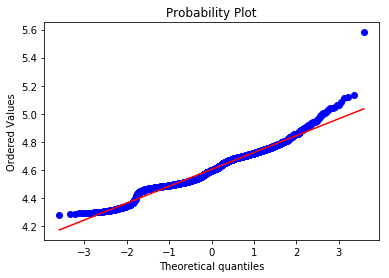

In [7]:
print ("Before Transformation : ")
print ("Skewness : {0}".format(stats.skew((train['y']))))
print ("Kurtosis : {0}".format(stats.kurtosis(train['y'])))

train['logy'] = np.log(train['y'])

print ("\nAfter Transformation : ")
print ("Skewness : {0}".format(stats.skew((train['logy']))))
print ("Kurtosis : {0}".format(stats.kurtosis(train['logy'])))

_, ax = plt.subplots()
prob = stats.probplot(train['logy'], plot=ax)

After transformation we see that the skewness and kurtosis are within acceptable range ie between +2 to -2. 

Now we will analyse our categorical variables.

## Categorical Varibles

In [11]:
train[cat_feat].describe()

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,47,27,44,7,4,29,12,25
top,z,aa,as,c,d,v,g,j
freq,360,833,1659,1942,4205,231,1042,277


Lets individually check X3, X4 as they have relatively few levels. 
#### X3

In [12]:
train['X3'].value_counts()
train['X3'].head(20)

c    1942
f    1076
a     440
d     290
g     241
e     163
b      57
Name: X3, dtype: int64

0     a
1     e
2     c
3     f
4     f
5     c
6     f
7     f
8     e
9     c
10    f
11    f
12    c
13    f
14    e
15    f
16    f
17    c
18    c
19    f
Name: X3, dtype: object

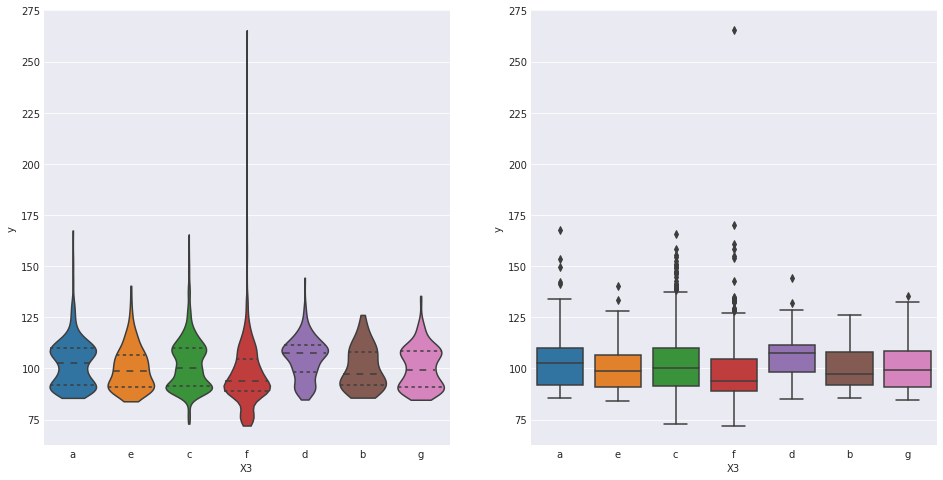

In [13]:
_, ax = plt.subplots(figsize=(16,8), ncols=2)
sns.violinplot(x='X3', y='y', data=train, cut=0, inner='quartile', ax=ax[0], scale='width')
sns.boxplot(x='X3', y='y', data=train, ax=ax[1])

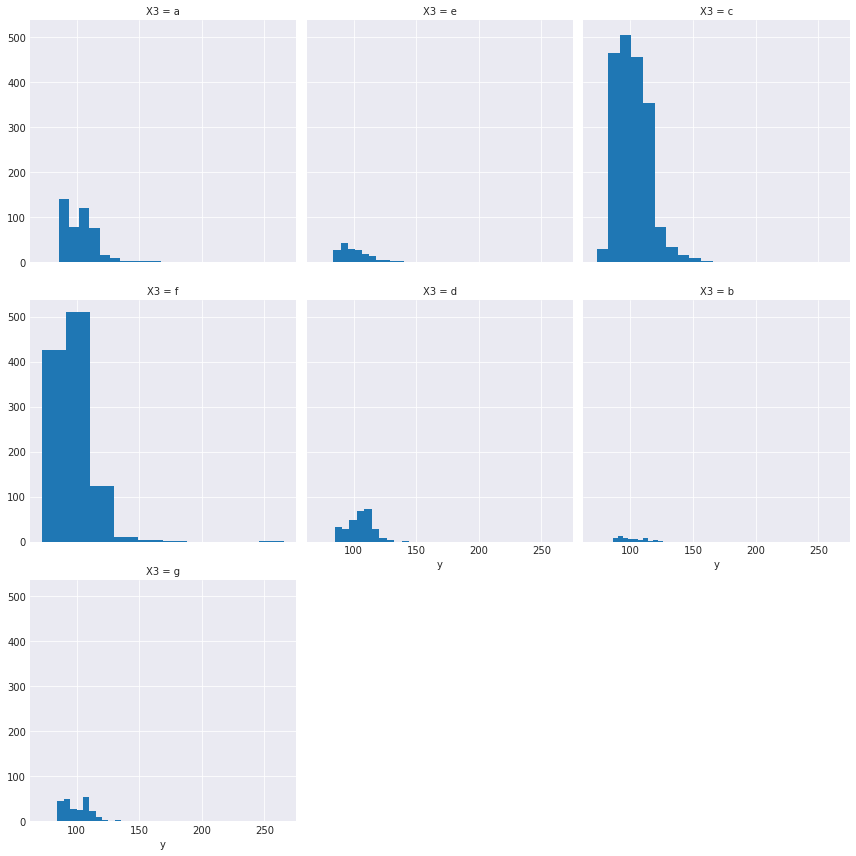

In [15]:
g = sns.FacetGrid(train, col_wrap=3, size=4, aspect=1, col='X3')
g = g.map(plt.hist, 'y')

Above 2 plots show quite a contrast in our target feature 'y' amongst various levels of X3. Target feature 'y' has a distinguishably different mean and distributions for levels c, f, d, b. So this feature X3 seems important but lets try to quantify our findings by runnings an ANOVA and see whether these changes in y are by chance or X3 is statiscally important. 

In [16]:
def anova(cat, num):
    samples = []
    for level in train[cat].unique():
        values = train.loc[train[cat]==level, [num]].values
        samples.append(values)
    f_stat, p_val = stats.f_oneway(*samples)
    print ("F Statistic : {0}".format(f_stat))
    print ("p value : {0}".format(p_val))

anova('X3', 'logy')

F Statistic : [ 37.54337884]
p value : [  1.30814734e-44]


With a high F-statistic and low p-value we can say that the differences in mean in target feature y/logy aren't by chance but due to X3. But to find out whether all levels make a significant difference we need to one-hot encode our variables and then conduct a t-test and find a p-value for each dummy variable. 
Let's try a similar analysis for X4 and X6

### X4


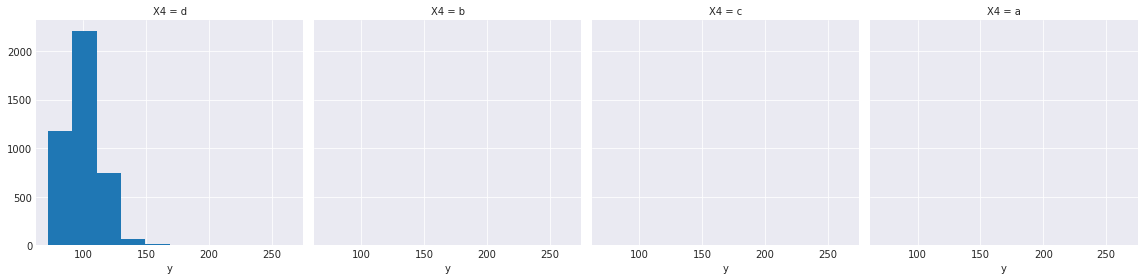

In [17]:
g = sns.FacetGrid(col='X4', data=train, col_wrap=4, size=4, aspect=1)
g = g.map(plt.hist, 'y')


In [18]:
train['X4'].value_counts()

d    4205
a       2
c       1
b       1
Name: X4, dtype: int64

As we see most of the values in X4 belong to level 'd' and thus this feature could be dropped for being a near zero variance predictor. 

### X6

In [19]:
train['X6'].value_counts()

g    1042
j    1039
d     625
i     488
l     478
a     206
h     190
k      43
c      38
b      28
f      20
e      12
Name: X6, dtype: int64

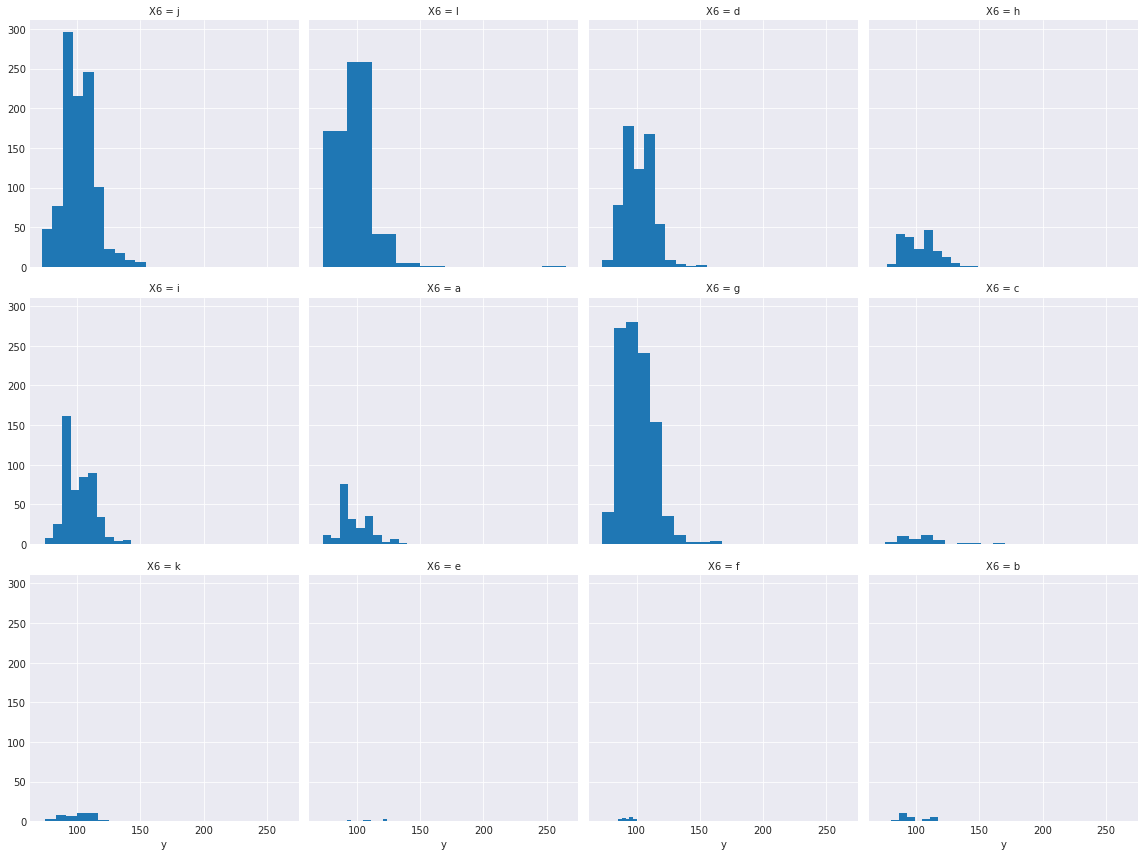

In [20]:
g = sns.FacetGrid(data=train, col='X6', size=4, aspect=1, col_wrap=4)
g.map(plt.hist, 'y')

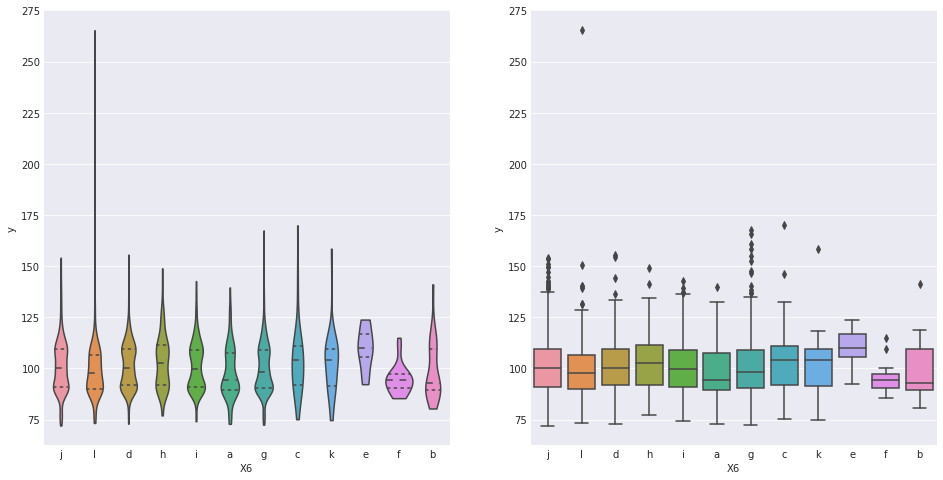

In [21]:
_, ax = plt.subplots(figsize=(16,8), ncols=2)
sns.violinplot(x='X6', y='y', data=train, ax=ax[0], cut=0, inner='quartile')
sns.boxplot(x='X6', y='y', data=train, ax=ax[1])

The plots show that the categories make a difference in the target feature. Let's verify this statistically. 

In [22]:
anova('X6', 'logy')

F Statistic : [ 4.53130894]
p value : [  7.37401319e-07]


Yup, X6 is also statiscally significant. So lets check p-value for each of the categorical features. 

In [23]:
for feat in cat_feat:
    print ('\n'+feat)
    anova(feat, 'logy')


X0
F Statistic : [ 156.42331616]
p value : [ 0.]

X1
F Statistic : [ 8.25031423]
p value : [  1.16538378e-30]

X2
F Statistic : [ 33.01281197]
p value : [  3.94362277e-229]

X3
F Statistic : [ 37.54337884]
p value : [  1.30814734e-44]

X4
F Statistic : [ 2.28399826]
p value : [ 0.07692973]

X5
F Statistic : [ 2.13206919]
p value : [ 0.00047722]

X6
F Statistic : [ 4.53130894]
p value : [  7.37401319e-07]

X8
F Statistic : [ 5.60662972]
p value : [  4.84094033e-17]


The features are statistically significant except for X4. And as we saw X4 is a near 0 variance predictorand so it is better to not include it in modelling. 

Let's now analyse our binary features. 
## Binary features

In [8]:
train1 = train.T.drop_duplicates().T
rem_feat = [f for f in list(train.columns) if f not in list(train1.columns)]
len(rem_feat)

# The above operation changes the data type of numeric features to 'object' so let's change them back. 
train1['y'] = pd.to_numeric(train1['y'])
train1['ID'] = pd.to_numeric(train['ID'])
train1['logy'] = pd.to_numeric(train['logy'])

56

This removes 56 duplicate features from train dataframe. `rem_feat` contains features that were removed. Let's also remove them from `test`. 

In [9]:
test1 = test.drop(rem_feat, axis=1)

In [10]:
var_df = pd.DataFrame(columns=['feature', 'variance'])
for feat in list(set(train1.columns)-set(cat_feat)) : 
    var_df.loc[var_df.shape[0],:] = list((feat, train1[feat].var()))
var_df = var_df.sort_values(by='variance', axis=0)
var_df

,feature,variance
137,X11,0
293,X207,0.000237586
256,X257,0.000237586
277,X259,0.000237586
107,X33,0.000237586
63,X210,0.000237586
91,X339,0.000237586
235,X95,0.000237586
8,X190,0.000237586
149,X280,0.000237586


There is one feature X11 which has 0 variance and many number of features that have near 0 variance. We can comfortably drop X11 but for other near-zero variance features I am not that comfortable to simply drop them without analysing further. So first let's drop X11. 

In [11]:
train1 = train1.drop('X11', axis=1)
test1 = test1.drop('X11', axis=1)

Now let's see how is our train-test data split. 

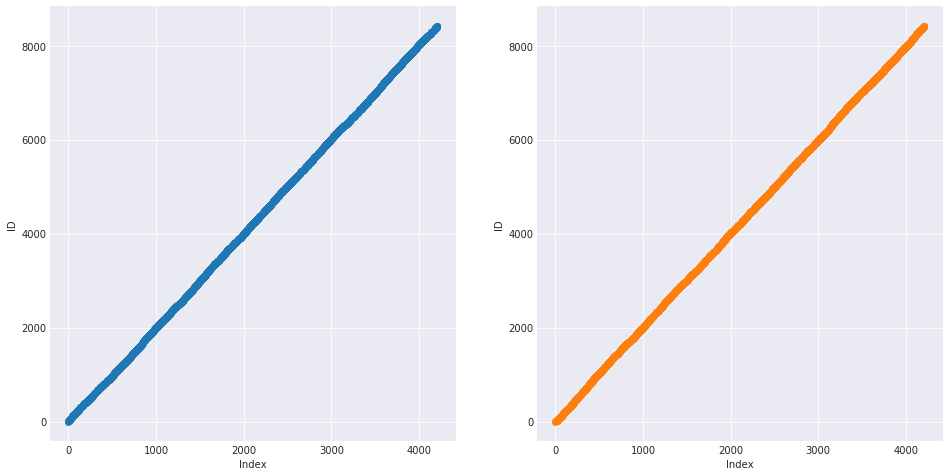

In [206]:
_, ax = plt.subplots(figsize=(16,8), ncols=2)
ax0=sns.regplot(train1.index.values, train1.ID, ax=ax[0], fit_reg=False, label='train')
ax1=sns.regplot(test.index.values, test.ID, ax=ax[1], fit_reg=False, label='test')
_=ax1.set_xlabel('Index')
_=ax0.set_xlabel('Index')


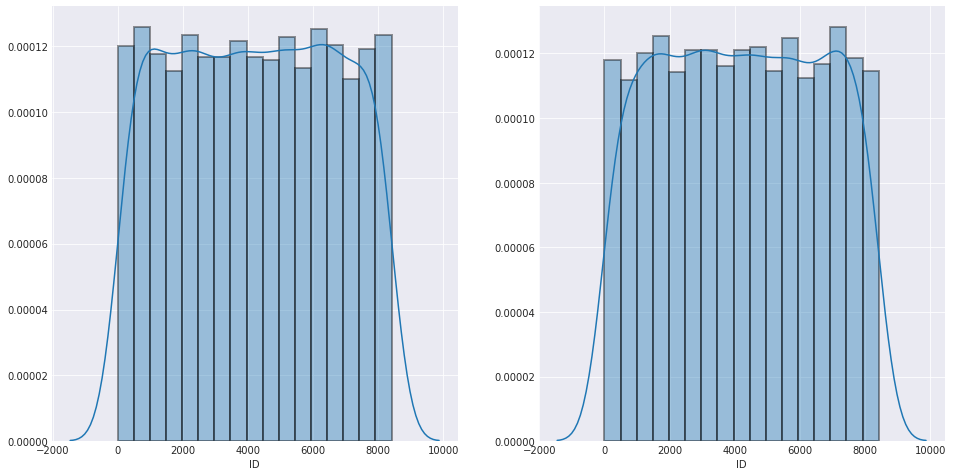

In [14]:
_,ax = plt.subplots(ncols=2, figsize=(16,8))
sns.distplot(train1['ID'], ax=ax[0], hist_kws=dict(edgecolor="k", linewidth=2))
sns.distplot(test['ID'], ax=ax[1], hist_kws=dict(edgecolor="k", linewidth=2))

The above 2 plots try to figure out on what basis test-train split has been made. `ID` feature is a unique ID of each row or each car. `ID` is distributed from 0 to 8417, each of test and train contanis half of them and from the histogram the distribution also looks close to random. 

So now we will try to fit a simple random forest model which could serve as our baseline model. 

### Random Forest

First we need to encode our features in `cat_feat`. We will try both label encoding and one hot encoding and see which gives better score. Also we need not out features in `num_feat` as they are already in binary form. 

In [93]:
# first label encode our cat_feat
encoder = LabelEncoder()
train_le = train1.copy()
test_le = test1.copy()
train_test = pd.concat(( train_le.drop(['y','logy'], axis=1) , test_le), axis=0, ignore_index=True)
for feat in cat_feat : 
    train_test.loc[:,feat] = encoder.fit_transform(train_test[feat])
    
train_le.loc[:,:] = train_test.loc[:train1.shape[0], :]
train_le.loc[:, 'y'] = train1.loc[:, 'y']
train_le.loc[:, 'logy'] = train1.loc[:, 'logy']
test_le = train_test.loc[train1.shape[0]:, :]

In [24]:
train[cat_feat].describe()
test[cat_feat].describe()

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,47,27,44,7,4,29,12,25
top,z,aa,as,c,d,w,g,j
freq,360,833,1659,1942,4205,231,1042,277


,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,49,27,45,7,4,32,12,25
top,ak,aa,as,c,d,v,g,e
freq,432,826,1658,1900,4203,246,1073,274


As we see in description of `cat_feat` in train and test, we notice that for features `X0`, `X2` and `X5` test has more levels that train. Let's analyse them more. 

In [84]:
exclusive_levels(train1, test1, cat_feat)

Exclusive X0
4 levels in train and not in test : ['aa', 'q', 'ab', 'ac']
6 levels in test and not in train : ['ae', 'ag', 'av', 'bb', 'an', 'p']
Exclusive X1
0 levels in train and not in test : []
0 levels in test and not in train : []
Exclusive X2
5 levels in train and not in test : ['ar', 'o', 'aa', 'c', 'l']
6 levels in test and not in train : ['ad', 'ab', 'w', 'ax', 'aj', 'u']
Exclusive X3
0 levels in train and not in test : []
0 levels in test and not in train : []
Exclusive X4
0 levels in train and not in test : []
0 levels in test and not in train : []
Exclusive X5
1 levels in train and not in test : ['u']
4 levels in test and not in train : ['t', 'z', 'b', 'a']
Exclusive X6
0 levels in train and not in test : []
0 levels in test and not in train : []
Exclusive X8
0 levels in train and not in test : []
0 levels in test and not in train : []


The function `exclusive_levels` prints the levels that are only present in either train or test. The output shows that in `X0`, `X2` and `X5` features have few levels that are only present in train or test. 
1. For the ones present only in train, we can encode them in test by all 0s. 
2. For the ones present only in test, we can delete/remove them as their encoding in train will be all zeros and will not provide any more information to our model while training. Also when our model will meet some of these level/features in test it will have no prior experience of these values and might give unexpected results. 

So for now we will concat train and test, one hot encode the combined dataframe, remove the features that are only present in test and separate them again. 

In [95]:
train_test = pd.concat((train1.drop(['y','logy'], axis=1), test1), axis=0, ignore_index=True)
train_test_ohe = pd.get_dummies(train_test, columns=cat_feat)
features = feat_to_rem(train1, test1, cat_feat)
train_test_ohe = train_test_ohe.drop(features, axis=1)
train_ohe.loc[:,:] = train_test_ohe[:train1.shape[0]]
train_ohe.loc[:,'y'] = train1['y']
train_ohe.loc[:,'logy'] = train1['logy']
test_ohe.loc[:,:] = train_test_ohe[train1.shape[0]:]

Function `feat_to_rem()` provides a list of features that should be removed according to the logic made above. 

So now we are ready to train our random forest model. 

In [110]:
X_le = train_le.drop(['y','logy'], axis=1)
y = train_le['y']
logy = train_le['logy']
scores = []
for estimators in tqdm(range(10, 200, 15)):
    rf = RandomForestRegressor(n_estimators=estimators, max_features='sqrt')
    scores.append(cross_val_score(rf, X_le, y, cv=5, scoring='r2', n_jobs=-1))


100%|██████████| 8/8 [02:42<00:00, 20.33s/it]


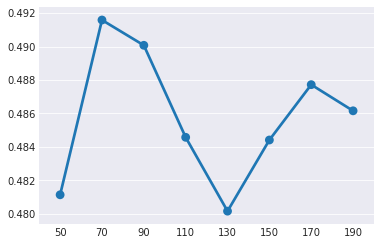

In [121]:
scores = np.array(scores)
sns.pointplot(x=list(range(10, 200, 20)), y=scores.mean(axis=1))

In [127]:
rf_le = RandomForestRegressor(n_estimators=300, max_features='sqrt')
cross_val_score(rf_le, X_le, y, cv=5, scoring='r2', n_jobs=-1)

array([ 0.40348714,  0.42258794,  0.55932638,  0.48035472,  0.56997768])

In [141]:
X_ohe = train_ohe.drop(['y','logy'], axis=1)

rf_ohe = RandomForestRegressor(n_estimators=300, max_features='sqrt')
cross_val_score(rf_ohe, X_ohe, y, cv=5, scoring='r2', n_jobs=-1)

array([ 0.44568826,  0.42439915,  0.57792551,  0.49871934,  0.58443737])

In [130]:
rf_le.fit(X_le, y)
rf_le.feature_importances_
rf_ohe.fit(X_ohe, y)
rf_ohe.feature_importances_


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

array([  7.65624453e-02,   3.12350032e-02,   8.54030669e-03,
         8.85804896e-03,   1.42287028e-02,   2.75191968e-04,
         4.67355008e-02,   3.10043541e-02,   2.44207446e-02,
         1.60225058e-04,   1.94991210e-03,   8.13374253e-04,
         3.13092176e-03,   8.78661665e-06,   1.52685683e-04,
         5.33182191e-04,   2.22788976e-04,   2.26988853e-03,
         1.71599678e-03,   3.08198414e-05,   8.92145314e-04,
         3.97754546e-04,   4.48005345e-05,   1.88098000e-04,
         3.31098255e-03,   3.90403655e-03,   1.86962108e-02,
         6.42341423e-05,   4.51095042e-03,   7.18014033e-05,
         1.32799521e-06,   2.42179304e-04,   1.02290588e-04,
         1.00659860e-03,   1.25923197e-05,   3.78018232e-04,
         1.38882381e-06,   1.64342831e-03,   7.95514222e-05,
         1.17150667e-03,   4.34912670e-03,   2.17980796e-03,
         7.89182893e-04,   1.30867421e-03,   2.32856646e-03,
         5.78156895e-03,   1.09194382e-03,   9.39047450e-05,
         1.24389865e-02,

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

array([  5.49457808e-02,   8.66677304e-05,   1.84645612e-03,
         8.14751606e-04,   3.41854476e-03,   1.23212963e-05,
         1.57976368e-04,   2.62432868e-04,   2.24952374e-04,
         1.85972647e-03,   1.54435474e-03,   2.89386944e-05,
         6.48603863e-04,   4.13267225e-04,   2.79493541e-05,
         1.50991164e-04,   3.37681197e-03,   3.11391732e-03,
         1.37265056e-02,   7.93511161e-05,   3.41232120e-03,
         4.95873349e-05,   1.68150393e-06,   2.55060936e-04,
         9.11234401e-05,   7.66625277e-04,   1.31205505e-05,
         2.75115500e-04,   3.55927829e-06,   1.01367736e-03,
         5.90930611e-05,   1.19240418e-03,   3.29371464e-03,
         2.03781560e-03,   1.02876470e-03,   1.45113196e-03,
         1.86162695e-03,   5.17331204e-03,   1.21479091e-03,
         2.21176129e-05,   1.41832592e-02,   6.00379299e-05,
         4.55478227e-04,   2.78366964e-04,   4.50664158e-03,
         7.04361101e-07,   1.88230974e-05,   1.20505550e-03,
         3.57626554e-04,

In [138]:
rf_le.feature_importances_.argmin()
rf_le.feature_importances_.argmax()
rf_ohe.feature_importances_.argmax()
rf_ohe.feature_importances_.argmin()

224

0

102

216

In [140]:
rf_le.estimators_[:3]

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=280896594, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=2060635922, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=903175054, splitter='best')]